In [1]:
%matplotlib inline

In [2]:
# Setup proxy as required
GA_STAFF_WIFI = False

import os
if GA_STAFF_WIFI:
    os.environ['http_proxy'] = 'http://proxy.inno.lan:3128'
    os.environ['https_proxy'] = 'http://proxy.inno.lan:3128'

In [3]:
import netCDF4
import numpy as np
from geophys_utils import NetCDFGridUtils
from geophys_utils import get_netcdf_edge_points, points2convex_hull
import matplotlib.pyplot as plt

In [4]:
# Open netCDF4 Dataset
netcdf_path = "/g/data1/rr2/National_Coverages/IR_gravity_anomaly_Australia_V1/IR_gravity_anomaly_Australia_V1.nc"
#netcdf_path = "http://dapds00.nci.org.au/thredds/dodsC/rr2/National_Coverages/IR_gravity_anomaly_Australia_V1/IR_gravity_anomaly_Australia_V1.nc"
#netcdf_path = "/g/data1/rr2/National_Coverages/magmap_v6_2015/magmap_v6_2015.nc"
#netcdf_path = "http://dapds00.nci.org.au/thredds/dodsC/rr2/National_Coverages/magmap_v6_2015/magmap_v6_2015.nc"
#netcdf_path = "http://dapds03.nci.org.au/thredds/dodsC/rr2/National_Coverages/magmap_v6_2015/magmap_v6_2015.nc"
netcdf_dataset = netCDF4.Dataset(netcdf_path, 'r')

#max_bytes = 500000000
max_bytes = 8000000000

nu = NetCDFGridUtils(netcdf_dataset)
print 'pixel_size = %s' % nu.pixel_size
print 'nominal_pixel_metres = %s' % nu.nominal_pixel_metres

pixel_size = [0.00833333, 0.00833333]
nominal_pixel_metres = [813.7147439908586, 936.8495566993952]


In [5]:
# Find edge points
# Note that we would normally use netcdf2convex_hull to go straight to the convex hull, but we want to plot the points
edge_points = np.array(get_netcdf_edge_points(netcdf_dataset, max_bytes=max_bytes))
print edge_points.shape

(56902, 2)


In [6]:
# Compute convex hull
# Note that we would normally use netcdf2convex_hull to go straight to the convex hull, but we want to plot the edge points
avg_pixel_size = (nu.pixel_size[0] + nu.pixel_size[1]) / 2.0
convex_hull = np.array(points2convex_hull(edge_points, avg_pixel_size, avg_pixel_size))
print convex_hull.shape

(29, 2)


In [7]:
# Obtain coordinates for sample points along transect
# Note that sample points between vertices are computed in UTM space for linear metres

#transect_vertices = ((110, -25), (155, -25))
#transect_vertices = ((110, -25), (115, -25), (120, -25), (125, -25), (130, -25), (135, -25), (140, -25), (145, -25), (150, -25), (155, -25))
transect_vertices = ((110, -25), (115, -25.5), (120, -26), (125, -26.5), (130, -27), (135, -27.5), (140, -28), (145, -28.5), (150, -29), (155, -29.5))

sample_points, sample_spacing = nu.sample_transect(transect_vertices, 'EPSG:4326')
print sample_spacing
sample_points = np.array(sample_points)
print sample_points.shape
print sample_points

1000.0
(6420, 2)
[[ 110.00058681  -25.00007929]
 [ 110.00701533  -25.00083967]
 [ 110.01344421  -25.00159979]
 ..., 
 [ 154.9786254   -29.49833979]
 [ 154.98580426  -29.49890279]
 [ 154.99298296  -29.49946532]]


In [8]:
# Obtain values for sample points
sample_values = np.array(nu.get_value_at_coords(sample_points, 'EPSG:4326', max_bytes=100))
print sample_values.shape

(6420,)


In [9]:
no_data_value = nu.data_variable._FillValue
good_data_mask = sample_values != no_data_value

good_sample_points = sample_points[good_data_mask]
bad_sample_points = sample_points[~good_data_mask]

sample_values[~good_data_mask] = np.NaN

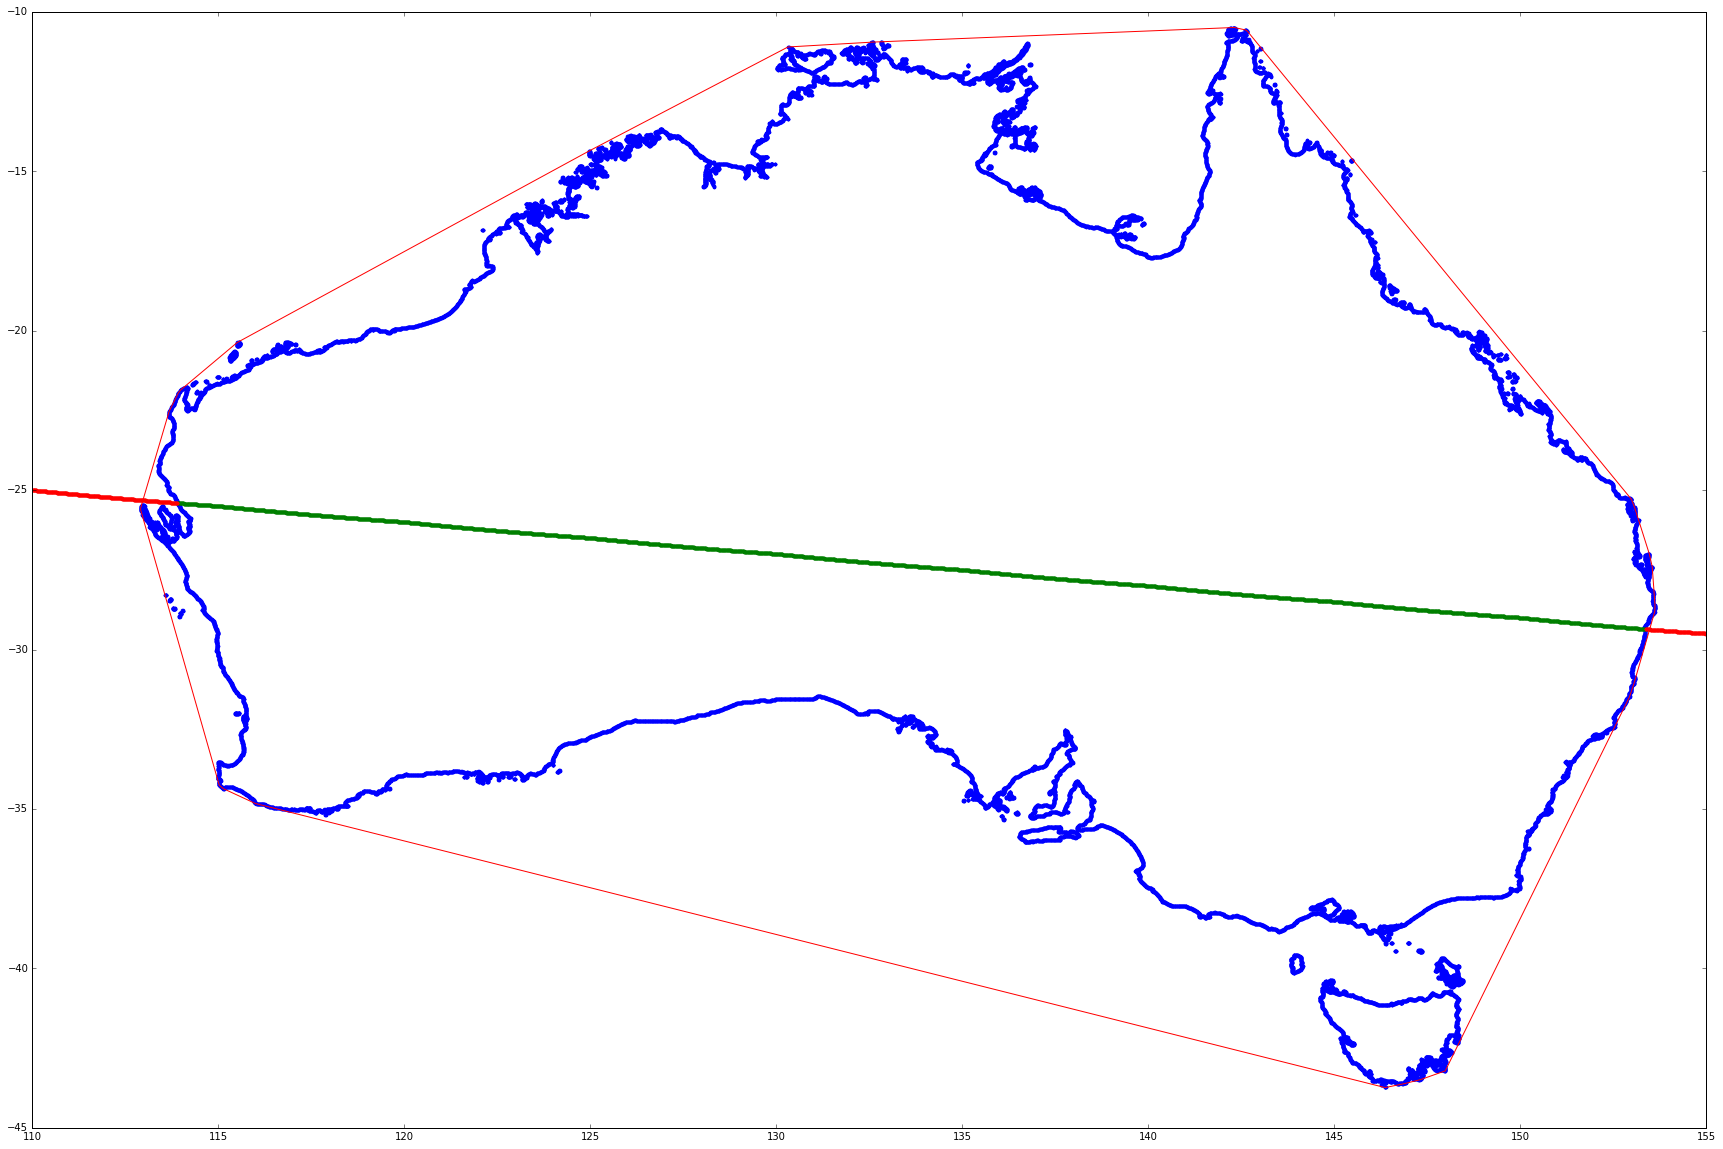

In [10]:
# Plot good and bad data points
plt.figure(figsize=(30,20))    
plt.plot(edge_points[:,0], edge_points[:,1], 'b.')
plt.plot(good_sample_points[:,0], good_sample_points[:,1], 'g.')
plt.plot(bad_sample_points[:,0], bad_sample_points[:,1], 'r.')
plt.plot(convex_hull[:,0], convex_hull[:,1], 'r-')

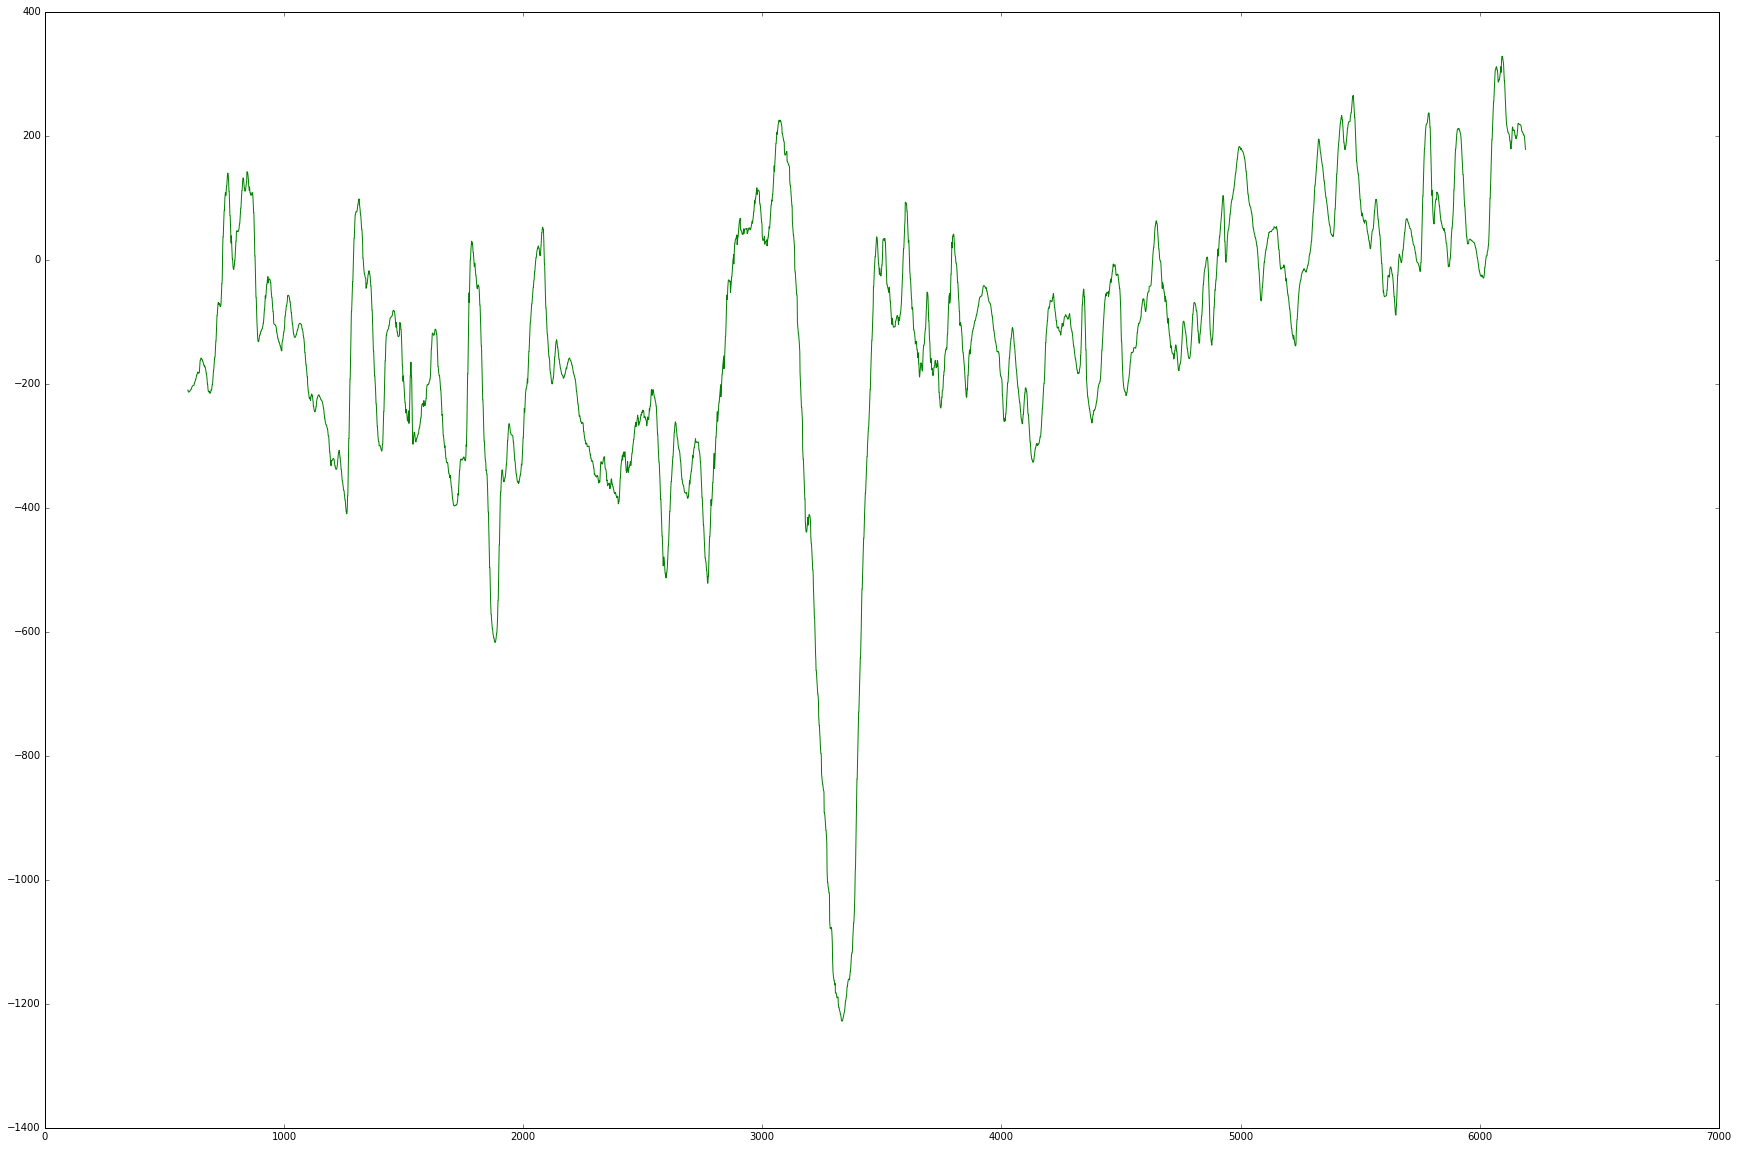

In [11]:
# Plot values against distance along transect
if sample_spacing >= 1000:
    x_increment = int(sample_spacing / 1000) # convert from m to km
else:
    x_increment = int(sample_spacing)
plt.figure(figsize=(30,20))    
plt.plot(range(0,len(sample_values) * x_increment, x_increment), sample_values, 'g-') # Show x in km